### Ver BAOs en Mock MultiDark

In [7]:
import pandas as pd
mock = pd.read_csv('../data/to_mock.csv')
len(mock)

12142272

In [10]:
# Cortamos en -21 por ahora
mock = mock[mock['magstarsdssr']<-21]
mock

,x,y,z,vx,vy,vz,magstarsdssr
1,25.54040,18.9353,29.7675,-280.47,37.10,66.41,-21.6621
5,30.32760,33.0084,168.3560,-4.85,-494.45,292.43,-21.6869
8,13.49250,37.3482,87.3615,-261.12,-37.36,408.61,-21.3148
15,9.98958,31.4000,550.5390,106.46,185.85,-84.59,-22.6706
16,61.44900,18.3671,539.3520,196.04,171.70,-284.69,-21.3221
...,...,...,...,...,...,...,...
12142256,51.94200,38.2797,344.7940,325.34,-731.41,162.91,-21.2596
12142258,39.03570,58.5106,407.5000,300.76,-790.41,-138.25,-21.0286
12142263,30.55580,33.0946,341.5570,135.61,-382.25,244.62,-21.9089
12142265,10.60820,61.3001,330.7390,-9.30,-629.43,213.28,-21.0389


In [11]:
mock['x'].max()

1000.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.utils import convert_3d_counts_to_cf
import pandas as pd 
import healpy as hp
from scipy.interpolate import interp1d
from numpy.polynomial.polynomial import Polynomial

def calculate_xi_mu_s(x_data, y_data, z_data, x_rand, y_rand, z_rand, bins, nmu_bins, boxsize, nthreads):
    """Calculate xi(mu, s) using Corrfunc."""

    # Pair counts with Corrfunc
    DD_counts = DDsmu(1, binfile=bins, nmu_bins=nmu_bins, \
        X1=x_data, Y1=y_data, Z1=z_data, mu_max=1., boxsize=boxsize, nthreads=nthreads)
    DR_counts = DDsmu(0, binfile=bins, nmu_bins=nmu_bins, \
        X1=x_data, Y1=y_data, Z1=z_data, X2=x_rand, Y2=y_rand, Z2=z_rand,\
            mu_max=1., boxsize=boxsize, nthreads=nthreads)
    RR_counts = DDsmu(1, binfile=bins, nmu_bins=nmu_bins, \
        X1=x_rand, Y1=y_rand, Z1=z_rand, mu_max=1., boxsize=boxsize, nthreads=nthreads)

    # Convert to correlation function
    xi = convert_3d_counts_to_cf(len(x_data), len(x_data), len(x_rand), len(x_rand), \
        DD_counts, DR_counts, DR_counts, RR_counts)
    return xi


# Step 5: Plot xi(mu, s)
def plot_xi_mu_s_contours(xi, bins, nmu_bins, filename):
    """Plot xi(mu, s) as a contour plot with s on the y-axis and mu on the inverted x-axis."""
    s_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    mu_bins = np.linspace(0, 1, nmu_bins + 1)
    mu_bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])  # Midpoints of mu bins

    xi = xi.reshape(len(s_bins), nmu_bins)

    # Create the contour plot
    plt.figure(figsize=(8, 6))
    cs = plt.contourf(mu_bin_centers, s_bins, xi, levels=20, cmap='viridis')  
    cbar = plt.colorbar(cs)
    cbar.set_label(r'$\xi(\mu, s)$')

    plt.gca().invert_xaxis()

    plt.xlabel(r'$\mu$')  # Negative mu since it's inverted
    plt.ylabel(r'$s \, [\mathrm{Mpc}/h]$')
    plt.title(r'Two-Point Correlation Function $\xi(\mu, s)$')
    plt.savefig(filename)
    plt.close()

def plot_xil(filename):

    def get_xi0246(xi,mu,rs):
    
        import numpy as np
        

        nbins_s = len(rs)-1
        nbins_m = len(mu)

        xi = xi.reshape(nbins_s, nbins_m)

        xi_sm = xi

        dmu = 1.0/nbins_m
        
        #rs = corr.D1D2.coords['r']
        #mu = corr.D1D2.coords['mu']
        
        xi_s0 = np.zeros(nbins_s)
        xi_s2 = np.zeros(nbins_s)
        xi_s4 = np.zeros(nbins_s)
        xi_s6 = np.zeros(nbins_s)
        
        sr = np.zeros(nbins_s)
        rm = np.zeros(nbins_m)
        
        l0 = 0.0
        l1 = 1.0
        l2 = 2.0
        l3 = 3.0
        
        for i in range(nbins_s):
            
            sr[i] = rs[i]
            
            for j in range(nbins_m):
                rm[j]=mu[j]
                xi_s0[i]  += (4.0*l0+1.0)*xi_sm[i,j]*1.0*dmu 
                xi_s2[i]  += (4.0*l1+1.0)*xi_sm[i,j]*((3*rm[j]**2 - 1.0)/2.0)*dmu
                xi_s4[i]  += (4.0*l2+1.0)*xi_sm[i,j]*((35*rm[j]**4 - 30*rm[j]**2 + 3.0)/8.0)*dmu
                xi_s6[i]  += (4.0*l3+1.0)*xi_sm[i,j]*((231*rm[j]**6 - 315*rm[j]**4 + 105*rm[j]**2 - 5)/16.0)*dmu
        
        return xi_s0, xi_s2, xi_s4, xi_s6

    # Load the data from the .npz file
    file_path = filename+'.npz'
    data = np.load(file_path)

    s = data['s']  # Edges of s bins
    mu = data['mu']  # 
    xi = data['xi']  # Structured array for 2D correlation function

    xi_l = get_xi0246(xi,np.linspace(0,1,mu),s)

    #nr = 2.5+np.linspace(5.,150.,nbins_s+1)[:-1]
    r = bins[:-1]
    plt.plot(r,(xi_l[0])*r**2,label=r'$\xi_0$',c='C00')
    #plt.plot(r,(-xi_l[1]),label=r'$\xi_2$',c='C01')
    #plt.plot(r,(r**2)*(-xi_l[2]),label=r'$\xi_4$',c='C02')

    plt.xlabel('s')
    plt.ylabel(r'$s^2\xi_{\ell}$')
    plt.legend()
    plt.savefig(filename+'_xil.png')
    plt.close()

# Main execution
if __name__ == "__main__":

    import time

    t1=time.time()

    #zmin, zmax = 0.05, 0.15
    nthreads = 4
    #sample = 'allgxs' #['filgxs','nonfilgxs','allgxs']

    # Read data
    mock = pd.read_csv('../data/to_mock.csv')
    mock = mock[mock['magstarsdssr']<-21]

    
    # Generate Randoms
    boxsize = 1000.
    Nran = len(mock)*3
    seed = 42
    np.random.seed(seed)
    xran = np.random.uniform(0, boxsize, Nran)
    yran = np.random.uniform(0, boxsize, Nran)
    zran = np.random.uniform(0, boxsize, Nran)

    # Dilute for testing
    #mock = mock.sample(n=500000)
    xran = xran[:len(mock)*5]
    yran = yran[:len(mock)*5]
    zran = zran[:len(mock)*5]


    # Calculate xi(mu, s)
    x = mock['x'].values
    y = mock['y'].values
    z = mock['z'].values
    bins = np.linspace(50, 150, 35)  # Separation bins in Mpc/h
    nmu_bins = len(bins)-1  # Number of mu bins
    xi = calculate_xi_mu_s(x, y, z, xran, yran, zran, bins=bins, nmu_bins=nmu_bins, boxsize=boxsize, nthreads=nthreads)

    # Plot xi(mu, s)
    filename = f'2dcorr_corrfunc_mock_Nd{len(mock)}_Nr{len(xran)}'
    plot_xi_mu_s_contours(xi, bins, nmu_bins, filename+'.png')

    # Save results
    np.savez(filename+'.npz', xi=xi, s=bins, mu=nmu_bins)

    # PLot xi_l
    plot_xil(filename)

    t2 = time.time()

    print((t2-t1)/60,'min')

### Hacer lo mismo pero suavizar randoms

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.utils import convert_3d_counts_to_cf
import pandas as pd 
import healpy as hp
from scipy.interpolate import interp1d
import scipy.ndimage as ndimage
from numpy.polynomial.polynomial import Polynomial

def convert_3d_counts_to_cfNAT(ND, NR, DD, RR, estimator='nat'):

    import numpy as np
    pair_counts = dict()
    fields = ['DD', 'RR']
    arrays = [DD, RR]
    for (field, array) in zip(fields, arrays):
        try:
            npairs = array['npairs']
            pair_counts[field] = npairs
        except IndexError:
            pair_counts[field] = array

    nbins = len(pair_counts['DD'])
    if (nbins != len(pair_counts['RR'])):
        msg = 'Pair counts must have the same number of elements (same bins)'
        raise ValueError(msg)

    nonzero = pair_counts['RR'] > 0
    if 'nat' in estimator:
        fN1 = np.float64(NR)*(np.float64(NR-1)) / (np.float64(ND)*np.float64(ND-1))
        cf = np.zeros(nbins)
        cf[:] = np.nan
        cf[nonzero] = fN1 * pair_counts['DD'][nonzero]  / pair_counts['RR'][nonzero] -1
        if len(cf) != nbins:
            msg = 'Bug in code. Calculated correlation function does not '\
                  'have the same number of bins as input arrays. Input bins '\
                  '={0} bins in (wrong) calculated correlation = {1}'.format(
                      nbins, len(cf))
            raise RuntimeError(msg)
    else:
        msg = "Only the Natural estimator is supported. Pass estimator"\
              "='nat'. (Got estimator = {0})".format(estimator)
        raise ValueError(msg)

    return cf

def convert_3d_counts_to_cfNAT_(ND, NR, DD, RR, estimator='nat'):

    import numpy as np
    #pair_counts = dict()
    #fields = ['DD', 'RR']
    #arrays = [DD, RR]
    #for (field, array) in zip(fields, arrays):
    #    try:
    #        npairs = array['npairs']
    #        pair_counts[field] = npairs
    #    except IndexError:
    #        pair_counts[field] = array

    #nbins = len(pair_counts['DD'])
    #if (nbins != len(pair_counts['RR'])):
    #    msg = 'Pair counts must have the same number of elements (same bins)'
    #    raise ValueError(msg)

    nonzero = RR > 0
    if 'nat' in estimator:
        fN1 = np.float64(NR)*(np.float64(NR-1)) / (np.float64(ND)*np.float64(ND-1))
        #cf = np.zeros(nbins)
        #cf[:] = np.nan
        cf = fN1 * DD[nonzero]  / RR[nonzero] -1
        #if len(cf) != nbins:
        #    msg = 'Bug in code. Calculated correlation function does not '\
        #          'have the same number of bins as input arrays. Input bins '\
        #          '={0} bins in (wrong) calculated correlation = {1}'.format(
        #              nbins, len(cf))
        #    raise RuntimeError(msg)
    else:
        msg = "Only the Natural estimator is supported. Pass estimator"\
              "='nat'. (Got estimator = {0})".format(estimator)
        raise ValueError(msg)

    return cf

def calculate_xi_smu(x_data, y_data, z_data, x_rand, y_rand, z_rand, bins, nmu_bins, boxsize, nthreads, smooth_rand=True):
    """Calculate xi(mu, s) using Corrfunc."""

    # Pair counts with Corrfunc
    DD_counts = DDsmu(1, binfile=bins, nmu_bins=nmu_bins, \
        X1=x_data, Y1=y_data, Z1=z_data, mu_max=1., boxsize=boxsize, nthreads=nthreads)
    RR_counts = DDsmu(1, binfile=bins, nmu_bins=nmu_bins, \
        X1=x_rand, Y1=y_rand, Z1=z_rand, mu_max=1., boxsize=boxsize, nthreads=nthreads)

    if smooth_rand==True:
        # Apply Gaussian smoothing
        sigma_s = .1  # Smoothing scale along s
        sigma_mu = .01  # Smoothing scale along mu
        RR_smoothed_pairs = ndimage.gaussian_filter(RR_counts['npairs'].reshape(len(bins)-1, nmu_bins), sigma=(sigma_s, sigma_mu),\
             mode='nearest')
        #RR_counts['npairs'] = RR_smoothed_pairs.flatten()

        # Convert to correlation function
        xi = convert_3d_counts_to_cfNAT_(len(x_data), len(x_rand), DD_counts['npairs'], RR_smoothed_pairs.reshape(-1))
    else:
        xi = convert_3d_counts_to_cf(len(x_data), len(x_data), len(x_rand), len(x_rand), \
            DD_counts, DR_counts, DR_counts, RR_counts)
    return xi


# Step 5: Plot xi(mu, s)
def plot_xi_mu_s_contours(xi, bins, nmu_bins, filename):
    """Plot xi(mu, s) as a contour plot with s on the y-axis and mu on the inverted x-axis."""
    s_bins = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of s bins
    mu_bins = np.linspace(0, 1, nmu_bins + 1)
    mu_bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])  # Midpoints of mu bins

    xi = xi.reshape(len(s_bins), nmu_bins)

    # Create the contour plot
    plt.figure(figsize=(8, 6))
    cs = plt.contourf(mu_bin_centers, s_bins, xi, levels=20, cmap='viridis')  
    cbar = plt.colorbar(cs)
    cbar.set_label(r'$\xi(\mu, s)$')

    plt.gca().invert_xaxis()

    plt.xlabel(r'$\mu$')  # Negative mu since it's inverted
    plt.ylabel(r'$s \, [\mathrm{Mpc}/h]$')
    plt.title(r'Two-Point Correlation Function $\xi(\mu, s)$')
    plt.savefig(filename)
    plt.close()

def plot_xil(filename):

    def get_xi0246(xi,mu,rs):
    
        import numpy as np
        

        nbins_s = len(rs)-1
        nbins_m = len(mu)

        xi = xi.reshape(nbins_s, nbins_m)

        xi_sm = xi

        dmu = 1.0/nbins_m
        
        #rs = corr.D1D2.coords['r']
        #mu = corr.D1D2.coords['mu']
        
        xi_s0 = np.zeros(nbins_s)
        xi_s2 = np.zeros(nbins_s)
        xi_s4 = np.zeros(nbins_s)
        xi_s6 = np.zeros(nbins_s)
        
        sr = np.zeros(nbins_s)
        rm = np.zeros(nbins_m)
        
        l0 = 0.0
        l1 = 1.0
        l2 = 2.0
        l3 = 3.0
        
        for i in range(nbins_s):
            
            sr[i] = rs[i]
            
            for j in range(nbins_m):
                rm[j]=mu[j]
                xi_s0[i]  += (4.0*l0+1.0)*xi_sm[i,j]*1.0*dmu 
                xi_s2[i]  += (4.0*l1+1.0)*xi_sm[i,j]*((3*rm[j]**2 - 1.0)/2.0)*dmu
                xi_s4[i]  += (4.0*l2+1.0)*xi_sm[i,j]*((35*rm[j]**4 - 30*rm[j]**2 + 3.0)/8.0)*dmu
                xi_s6[i]  += (4.0*l3+1.0)*xi_sm[i,j]*((231*rm[j]**6 - 315*rm[j]**4 + 105*rm[j]**2 - 5)/16.0)*dmu
        
        return xi_s0, xi_s2, xi_s4, xi_s6

    # Load the data from the .npz file
    file_path = filename+'.npz'
    data = np.load(file_path)

    s = data['s']  # Edges of s bins
    mu = data['mu']  # 
    xi = data['xi']  # Structured array for 2D correlation function

    xi_l = get_xi0246(xi,np.linspace(0,1,mu),s)

    #nr = 2.5+np.linspace(5.,150.,nbins_s+1)[:-1]
    r = bins[:-1]
    plt.plot(r,(xi_l[0])*r**2,label=r'$\xi_0$',c='C00')
    #plt.plot(r,(-xi_l[1]),label=r'$\xi_2$',c='C01')
    #plt.plot(r,(r**2)*(-xi_l[2]),label=r'$\xi_4$',c='C02')

    plt.xlabel('s')
    plt.ylabel(r'$s^2\xi_{\ell}$')
    plt.legend()
    plt.savefig(filename+'_xil.png')
    print('Saved '+filename+'_xil.png')
    plt.close()

# Main execution
if __name__ == "__main__":

    import time

    t1=time.time()

    #zmin, zmax = 0.05, 0.15
    nthreads = 4
    #sample = 'allgxs' #['filgxs','nonfilgxs','allgxs']
    smooth_rand = True

    # Read data
    mock = pd.read_csv('../data/to_mock.csv')
    mock = mock[mock['magstarsdssr']<-21]

    
    # Generate Randoms
    boxsize = 1000.
    Nran = len(mock)*3
    seed = 42
    np.random.seed(seed)
    xran = np.random.uniform(0, boxsize, Nran)
    yran = np.random.uniform(0, boxsize, Nran)
    zran = np.random.uniform(0, boxsize, Nran)

    # Dilute for testing
    mock = mock.sample(n=50_000)
    xran = xran[:len(mock)*3]
    yran = yran[:len(mock)*3]
    zran = zran[:len(mock)*3]


    # Calculate xi(mu, s)
    x = mock['x'].values
    y = mock['y'].values
    z = mock['z'].values
    bins = np.linspace(50, 150, 20)  # Separation bins in Mpc/h
    nmu_bins = len(bins)-1  # Number of mu bins
    xi = calculate_xi_smu(x, y, z, xran, yran, zran, bins=bins, nmu_bins=nmu_bins, boxsize=boxsize, \
                            nthreads=nthreads, smooth_rand=smooth_rand)

    # Plot xi(mu, s)
    filename = f'2dcorr_corrfunc_mock_Nd{len(mock)}_Nr{len(xran)}'
    if smooth_rand==True: filename+='smooth'
    plot_xi_mu_s_contours(xi, bins, nmu_bins, filename+'.png')

    # Save results
    np.savez(filename+'.npz', xi=xi, s=bins, mu=nmu_bins)

    # PLot xi_l
    plot_xil(filename)

    t2 = time.time()

    print((t2-t1)/60,'min')

Saved 2dcorr_corrfunc_mock_Nd50000_Nr150000smooth_xil.png
0.22907762130101522 min


### Check N_pairs_RR(s) vs s

In [37]:
RR['npairs'].reshape(len(bins)-1, nmu_bins)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [41]:
import scipy.ndimage as ndimage

# Apply Gaussian smoothing
sigma_s = 2  # Smoothing scale along s
sigma_mu = 2  # Smoothing scale along mu
RR_smoothed = ndimage.gaussian_filter(RR['npairs'].reshape(len(bins)-1, nmu_bins), sigma=(sigma_s, sigma_mu))


In [47]:
RR['npairs']=RR_smoothed.flatten()

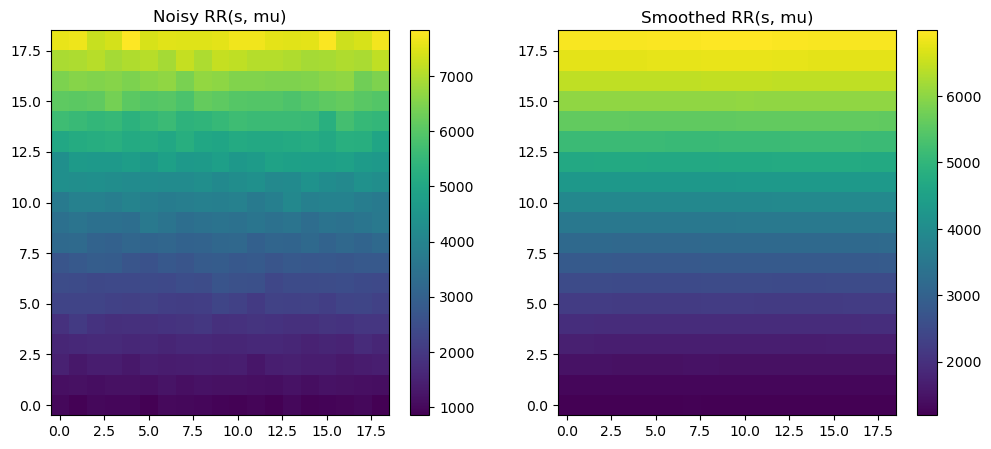

In [48]:

# Plot original vs. smoothed RR(s, mu)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im1 = ax[0].imshow(RR_counts['npairs'].reshape(len(bins)-1, nmu_bins), origin='lower', aspect='auto', cmap='viridis')
ax[0].set_title("Noisy RR(s, mu)")
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(RR_smoothed_pairs, origin='lower', aspect='auto', cmap='viridis')
ax[1].set_title("Smoothed RR(s, mu)")
fig.colorbar(im2, ax=ax[1])

plt.show()

In [38]:
RR_counts = DDsmu(1, binfile=bins, nmu_bins=nmu_bins, \
    X1=xran[:10_000], Y1=yran[:10_000], Z1=zran[:10_000], mu_max=1., boxsize=boxsize, nthreads=nthreads)


In [39]:
import scipy.ndimage as ndimage

if smooth_rand==True:
    # Apply Gaussian smoothing
    sigma_s = 2  # Smoothing scale along s
    sigma_mu = 2  # Smoothing scale along mu
    RR_smoothed_pairs = ndimage.gaussian_filter(RR_counts['npairs'].reshape(len(bins)-1, nmu_bins), sigma=(sigma_s, sigma_mu))
    #RR_counts['npairs']=RR_smoothed_pairs.flatten()

In [52]:
RR_counts['npairs'] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,